<h1>Bayes estimation for blood-feeding experiments</h1>

In [1]:
#Load packages
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import functools as fp
from scipy import stats

In [29]:
plt.rcParams['figure.figsize'] = 18, 12
np.random.seed(0)
print('Running on PyMC v{}'.format(pm.__version__))

Running on PyMC v5.3.1


In [4]:
#load dataset
descData = pd.read_csv("../data/2019_04_23_Dados_mosq.csv")
descData.head()

,Patient,sexo,gametocitemia,tipo,sugar/honey,mosquito,n,engorged,dissection,survival
0,170605-01,M,150,WB,sugar,An aquasalis,100,42,21,50.0
1,170605-02,M,210,WB,sugar,An aquasalis,100,48,28,58.3
2,170516-01,M,90,WB,sugar,An aquasalis,100,24,18,75.0
3,170525-01,M,120,WB,sugar,An aquasalis,100,49,31,63.3
4,2284,M,801,WB,sugar,An aquasalis,60,46,45,97.8


In [5]:
#Select paired assay
ids = ["2324", "2285", "2349", "2355", "2359", "2360"]

In [6]:
#Filter data
descData = descData[descData["Patient"].isin(ids)]
descData

,Patient,sexo,gametocitemia,tipo,sugar/honey,mosquito,n,engorged,dissection,survival
27,2324,F,540,WB,sugar,An aquasalis,50,39,39,100.0
28,2324,F,540,WB,sugar,An deaneorum,50,40,32,80.0
29,2324,F,540,WB,sugar,An darlingi,50,30,20,66.7
30,2285,M,1050,WB,sugar,An aquasalis,30,25,25,100.0
31,2285,M,1050,WB,sugar,An deaneorum,30,30,27,90.0
32,2285,M,1050,WB,sugar,An darlingi,30,25,25,100.0
33,2349,M,180,WB,sugar,An aquasalis,30,30,30,100.0
34,2349,M,180,WB,sugar,An deaneorum,30,20,18,90.0
35,2349,M,180,WB,sugar,An darlingi,30,30,19,63.3
36,2355,M,630,WB,sugar,An aquasalis,50,41,41,100.0


In [7]:
#Number of mosquitoes used
np.sum(descData["n"])

660

In [8]:
#Females by species
descData.groupby(["mosquito"])["n"].agg(total = sum)

,total
mosquito,
An aquasalis,250
An darlingi,185
An deaneorum,225


In [9]:
#Compute engordeg mosquitoes
descData = descData.assign(propEngo = descData["engorged"]/descData["n"])
descData.groupby(["mosquito"]).agg({"n":"sum", "engorged": "sum", "propEngo": "mean"})

,n,engorged,propEngo
mosquito,,,
An aquasalis,250,195,0.788889
An darlingi,185,149,0.832222
An deaneorum,225,204,0.906349


In [10]:
#Compute engordeg mosquitoes
descData = descData.assign(propDissec = descData["dissection"]/descData["engorged"])
descData.groupby(["mosquito"]).agg({ "engorged": "sum","dissection": "sum", "propDissec": "mean"})

,engorged,dissection,propDissec
mosquito,,,
An aquasalis,195,193,0.983333
An darlingi,149,116,0.790338
An deaneorum,204,186,0.910294


In [13]:
#load data for infection
MosqInfect = pd.read_csv("../data/2019_10_25_dados_infec.csv")
MosqInfect.head()

,Unnamed: 0,ind,mosquito,infec,n_oocistos,classe,sex,paciente,gametocitemia,tipo,sugar/honey
0,1,1,An aquasalis,1,101,NaN,M,170605-01,150,WB,sugar
1,2,2,An aquasalis,1,110,NaN,M,170605-01,150,WB,sugar
2,3,3,An aquasalis,1,80,NaN,M,170605-01,150,WB,sugar
3,4,4,An aquasalis,1,2,NaN,M,170605-01,150,WB,sugar
4,5,5,An aquasalis,1,115,NaN,M,170605-01,150,WB,sugar


In [14]:
#filter data
MosqInfect = MosqInfect[MosqInfect["paciente"].isin(ids)]
MosqInfect.head()

,Unnamed: 0,ind,mosquito,infec,n_oocistos,classe,sex,paciente,gametocitemia,tipo,sugar/honey
701,1,1004,An aquasalis,1,21,NaN,F,2324,540,WB,sugar
702,2,1005,An aquasalis,1,27,NaN,F,2324,540,WB,sugar
703,3,1006,An aquasalis,1,35,NaN,F,2324,540,WB,sugar
704,4,1007,An aquasalis,1,48,NaN,F,2324,540,WB,sugar
705,5,1008,An aquasalis,1,97,NaN,F,2324,540,WB,sugar


In [15]:
MosqInfect = MosqInfect.assign(n = 1)
bayesModel = MosqInfect.groupby(["mosquito","paciente"]).agg({"infec": "sum", "n": "sum"}).reset_index()
bayesModel.head()

,mosquito,paciente,infec,n
0,An aquasalis,2285,25,25
1,An aquasalis,2324,30,39
2,An aquasalis,2349,21,30
3,An aquasalis,2355,41,41
4,An aquasalis,2359,20,40


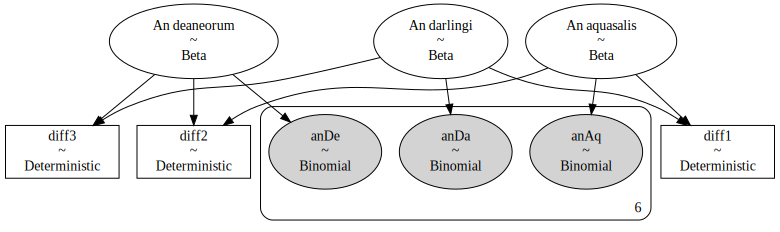

In [16]:
with pm.Model() as group_estimation:
    
    #give priors
    thetaAq = pm.Beta("An aquasalis", alpha = 0.5, beta = 0.5)
    thetaDa = pm.Beta("An darlingi", alpha = 0.5, beta = 0.5)
    thetaDe = pm.Beta("An deaneorum", alpha = 0.5, beta = 0.5)
    
    
    #compute differences
     #Compute differences
    diff1 = pm.Deterministic("diff1", thetaDa - thetaAq)
    
    diff2 = pm.Deterministic("diff2", thetaDe - thetaAq)
    
    diff3 = pm.Deterministic("diff3", thetaDa - thetaDe)
    
    
    #lilelihood
    anAq = pm.Binomial("anAq", n = bayesModel[bayesModel["mosquito"] == "An aquasalis"]["n"] , 
                       p = thetaAq, 
                       observed = bayesModel[bayesModel["mosquito"] == "An aquasalis"]["infec"])
    
    anDe = pm.Binomial("anDe", n = bayesModel[bayesModel["mosquito"] == "An deaneorum"]["n"] , 
                       p = thetaDe, 
                       observed = bayesModel[bayesModel["mosquito"] == "An deaneorum"]["infec"])
    
    anDa = pm.Binomial("anDa", n = bayesModel[bayesModel["mosquito"] == "An darlingi"]["n"] , 
                       p = thetaDa, 
                       observed = bayesModel[bayesModel["mosquito"] == "An darlingi"]["infec"])


pm.model_to_graphviz(group_estimation)

In [19]:
with group_estimation:
    
    step = pm.NUTS()
    groupTrace = pm.sample(draws = 20000, step = step, chains = 4, cores = 4, tune = 5000, init = 'adapt_diag')

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [An aquasalis, An darlingi, An deaneorum]


Sampling 4 chains for 5_000 tune and 20_000 draw iterations (20_000 + 80_000 draws total) took 7 seconds.


In [20]:
pm.summary(groupTrace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
An aquasalis,0.771,0.030,0.713,0.826,0.0,0.0,99060.0,60876.0,1.0
An darlingi,0.979,0.013,0.954,0.998,0.0,0.0,79679.0,50326.0,1.0
An deaneorum,0.906,0.021,0.867,0.945,0.0,0.0,109340.0,63196.0,1.0
diff1,0.208,0.033,0.146,0.270,0.0,0.0,97455.0,56672.0,1.0
diff2,0.136,0.037,0.066,0.204,0.0,0.0,102628.0,63824.0,1.0
diff3,0.072,0.025,0.024,0.119,0.0,0.0,103719.0,62269.0,1.0


In [30]:
fig, ax = plt.subplots(2, 2, figsize = (32, 28), dpi = 300)
pos = [(k,l) for k in range(2) for l in (0, 1)]
post = [None, "diff1", "diff2", "diff3"]
text = ["(A)", "(B)", "(C)", "(D)"]
for graph, (k,l), t in zip(post, pos, text):
    if k == 0 and l == 0:
        ax[k,l].set_xlim(0,1)
        ax[k,l].scatter([0.77, 0.90, 0.97],["An aquasalis","An deaneorum","An darlingi"], s = [28,28,28])
        ax[k,l].axhline(y = "An aquasalis", xmin = 0.71, xmax = 0.83)
        ax[k,l].axhline(y = "An deaneorum", xmin = 0.86, xmax = 0.94)
        ax[k,l].axhline(y = "An darlingi", xmin = 0.95, xmax = 0.99)
        ax[k, l].set_yticklabels(labels = ["An aquasalis","An deaneorum","An darlingi"], fontsize = 36, style = 'italic')
        ax[k, l].set_xticklabels(labels = [0,0.2,0.4,0.6,0.8,1],fontsize = 36)
        ax[k, l].set_title(label = t,loc = "right", fontsize = 36)
               
    else:
        pm.plot_posterior(groupTrace["posterior"][graph], ref_val = 0, ax = ax[k, l], color='skyblue', textsize = 36)
        #ax[k, l].set_xlabel("$\dot{\Theta}" "_{0}" "-" "\dot{\Theta}{}" "_{1}$", fontsize = 14)
        ax[k, l].set_title(None)
        ax[k, l].set_title(label = t,loc = "right", fontsize = 36)

/tmp/ipykernel_153302/1707725864.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[k, l].set_yticklabels(labels = ["An aquasalis","An deaneorum","An darlingi"], fontsize = 36, style = 'italic')
/tmp/ipykernel_153302/1707725864.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[k, l].set_xticklabels(labels = [0,0.2,0.4,0.6,0.8,1],fontsize = 36)


In [27]:
#remove non infected mosquitoes
MosqInfect = MosqInfect[MosqInfect["infec"] == 1]

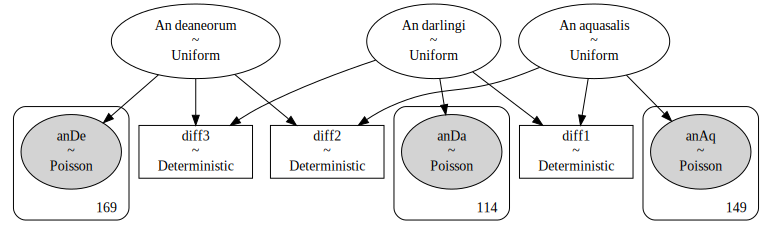

In [28]:
with pm.Model() as intensityEstimation:
    
    
    #give priors
    lambdaAq = pm.Uniform("An aquasalis", lower = 1, upper = 200)
    lambdaDa = pm.Uniform("An darlingi", lower = 1, upper = 200)
    lambdaDe = pm.Uniform("An deaneorum", lower = 1, upper = 200)
    
    
    #compute differences
    diff1 = pm.Deterministic("diff1", lambdaDa - lambdaAq)
    
    diff2 = pm.Deterministic("diff2", lambdaDe - lambdaAq)
    
    diff3 = pm.Deterministic("diff3", lambdaDa - lambdaDe)
    
    
    #lilelihood
    anAq = pm.Poisson("anAq", mu = lambdaAq, observed = MosqInfect[MosqInfect["mosquito"] == "An aquasalis"]["n_oocistos"])
    
    anDe = pm.Poisson("anDe", mu = lambdaDe, observed = MosqInfect[MosqInfect["mosquito"] == "An deaneorum"]["n_oocistos"])
    
    anDa = pm.Poisson("anDa", mu = lambdaDa, observed = MosqInfect[MosqInfect["mosquito"] == "An darlingi"]["n_oocistos"])


pm.model_to_graphviz(intensityEstimation)

In [31]:
with intensityEstimation:
    
    step = pm.NUTS()
    intensityTrace = pm.sample(draws = 20000, step = step, chains = 2, cores = 2, tune = 5000, init = 'adapt_diag')

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [An aquasalis, An darlingi, An deaneorum]


Sampling 2 chains for 5_000 tune and 20_000 draw iterations (10_000 + 40_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [33]:
pm.summary(intensityTrace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
An aquasalis,87.887,0.766,86.396,89.271,0.003,0.002,59383.0,29918.0,1.0
An darlingi,141.604,1.119,139.478,143.705,0.004,0.003,64900.0,31733.0,1.0
An deaneorum,122.711,0.852,121.141,124.361,0.004,0.002,58599.0,32586.0,1.0
diff1,53.717,1.358,51.157,56.262,0.005,0.004,61258.0,31882.0,1.0
diff2,34.825,1.149,32.673,36.975,0.005,0.003,59042.0,32780.0,1.0
diff3,18.893,1.400,16.295,21.581,0.005,0.004,65361.0,31331.0,1.0


array([<AxesSubplot:title={'center':'An aquasalis'}>,
       <AxesSubplot:title={'center':'An darlingi'}>,
       <AxesSubplot:title={'center':'An deaneorum'}>], dtype=object)

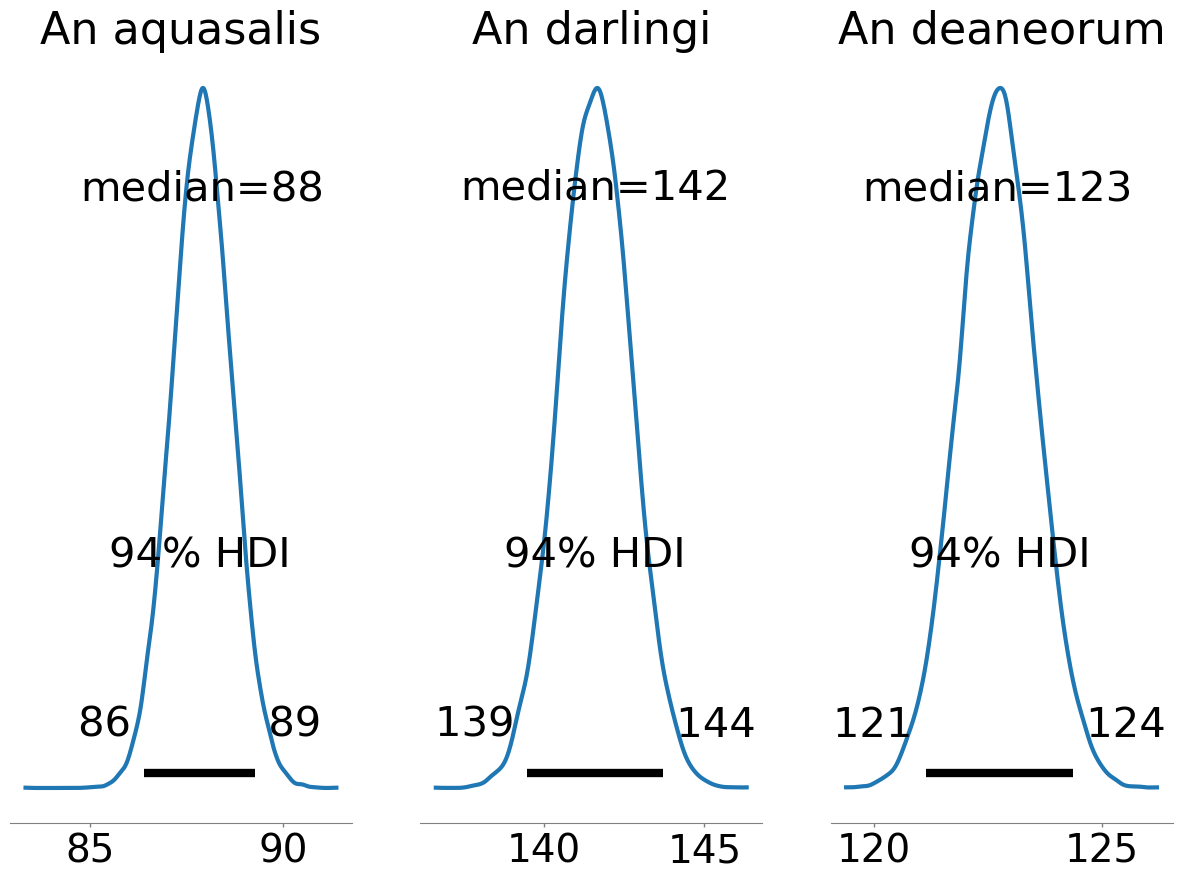

In [39]:
pm.plot_posterior(intensityTrace, var_names = ["An aquasalis", "An darlingi", "An deaneorum"], point_estimate = "median", textsize = 28, figsize = [15,10])